In [30]:
import torch
import numpy
import os
import argparse
import random
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

import umap
import umap.plot

from crowd_datasets import build_dataset
from engine import *
from models import build_model
from models.matcher import build_matcher_crowd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signatur

In [3]:
# load in models and dataset
result_dir = "results/updateset_highres_emb_FPN1_r1_c1/" 
model_dir =  "weights/best_mae.pth"
data_dir = "dataroot/updated_all_images"

# load in the arugments from the result di 
def load_args(filepath):
    with open(filepath, 'r') as f:
        namespace_str = f.read().strip()
    
    # Remove "Namespace(" from beginning and ")" from end
    params_str = namespace_str[10:-1]
    
    # Parse the parameters into a dictionary
    params = {}
    for param in params_str.split(','):
        if '=' in param:
            key, value = param.split('=', 1)
            key = key.strip()
            value = value.strip()
            # Handle different value types
            if value.lower() == 'true':
                value = True
            elif value.lower() == 'false':
                value = False
            elif value.lower() == 'none':
                value = None
            else:
                try:
                    value = float(value) if '.' in value else int(value)
                except ValueError:
                    # If not a number, remove quotes if present
                    value = value.strip("'\"")
                    # make list if brakets are present
                    if '[' in value: value = list(value)

            params[key] = value
    
    return argparse.Namespace(**params)

args = load_args(os.path.join(result_dir, "args.txt"))

# hard code some args
args.loss = ['labels', 'points']
args.multiclass = ['embryo']
args.ce_coef = [1.0]
args.dataset_file = "WORM_VAL"
args.gpu_id = 1
args.equalize = True

print(args) 

# load in model
model = build_model(args)
checkpoint = torch.load(os.path.join(result_dir, model_dir), map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()


# import dataset
loading_data = build_dataset(args)

train_set, val_set = loading_data(
    data_dir,
    multiclass=args.multiclass,
    hsv=args.hsv,
    hse=args.hse,
    edges=args.edges,
    equalize=args.equalize,
)
# create the sampler used during training
sampler_val = torch.utils.data.SequentialSampler(val_set)

 
data_loader_val = DataLoader(
    val_set,
    1,
    sampler=sampler_val,
    drop_last=False,
    collate_fn=utils.collate_fn_crowd,
    num_workers=args.num_workers,
)

Namespace(lr=0.0001, lr_backbone='1e-05', batch_size=3, weight_decay=0.0001, epochs=400, lr_drop=100, clip_max_norm=0.1, frozen_weights=None, pre_weights=None, backbone='vgg16_bn', num_classes=1, set_cost_class=1, set_cost_point=0.05, loss=['labels', 'points'], label_loss_coef=1, point_loss_coef=0.02, dense_loss_coef=1.0, count_loss_coef=10.0, distance_loss_coef=1.0, eos_coef=0.5, ce_coef=[1.0], map_res=16, gauss_kernel_res=21, row=1, line=1, dataset_file='WORM_VAL', data_root='dataroot/updated_all_images/', expname='updateset_highres_emb_FPN1_r1_c1', output_dir='./results/', multiclass=['embryo'], hsv=False, hse=False, edges=False, sharpness=True, scale=True, num_patches=4, seed=42, resume=None, start_epoch=0, pointmatch=False, noreg=False, classifier=False, eval=False, num_workers=8, eval_freq=1, gpu_id=1, equalize=True)


Using cache found in /home/sposhiya/.cache/torch/hub/pytorch_vision_main
/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# run outputs 
conv_out = {}
def set_hook(name):
    def hook(model, input, output):
        conv_out[name] = output.detach()
    return hook


model.classification.conv1.register_forward_hook(set_hook("class_conv_1"))
model.classification.conv2.register_forward_hook(set_hook("class_conv_2"))
model.classification.output.register_forward_hook(set_hook("class_out"))
model.regression.conv1.register_forward_hook(set_hook("reg_conv_1"))
model.regression.conv2.register_forward_hook(set_hook("reg_conv_2"))
model.regression.output.register_forward_hook(set_hook("reg_out"))

X,Y = next(iter(data_loader_val))
X = X.to(device)
Y = [{k: v.to(device) for k, v in t.items()} for t in Y]
output = model(X)

In [5]:
# classify each point
pred_logits = output['pred_logits']
pred_points = output['pred_points']
pred_logits.size()

torch.Size([1, 304128, 2])

In [6]:
# perform hungarian matching
matcher = build_matcher_crowd(args)
indicies = matcher(output,Y)

In [81]:
embedding = conv_out['class_conv_2']
print(embedding.size())
# reshape embedding to appropriate size
embedding = embedding.squeeze(0)
embedding_full = embedding.view(-1, embedding.size(1) * embedding.size(2))
print(embedding_full.size())
embedding_full = embedding_full.permute(1,0)
embedding_full = embedding_full.cpu().numpy()
print(embedding.shape)
embedding = embedding_full[indicies[0][0].tolist()]
print(embedding.shape)

mask = np.ones(embedding_full.shape[0], dtype=bool)
mask[indicies[0][0].tolist()] = False
not_embedding = embedding_full[mask]
print(not_embedding.shape)
not_embedding_sub = np.random.choice(np.arange(not_embedding.shape[0]), 5000)
print(not_embedding_sub.shape)
not_emb = not_embedding[not_embedding_sub.tolist()]
print(not_emb.shape)

embedding = np.concatenate((embedding, not_emb), axis=0)
print(embedding.shape)

# now make labels
lab = np.zeros(embedding.shape[0])
lab[866:] = 1

torch.Size([1, 256, 528, 576])
torch.Size([256, 304128])
torch.Size([256, 528, 576])
(886, 256)
(303242, 256)
(5000,)
(5000, 256)
(5886, 256)


In [82]:
mapper = umap.UMAP().fit(embedding)

/home/sposhiya/.conda/envs/pytorch/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

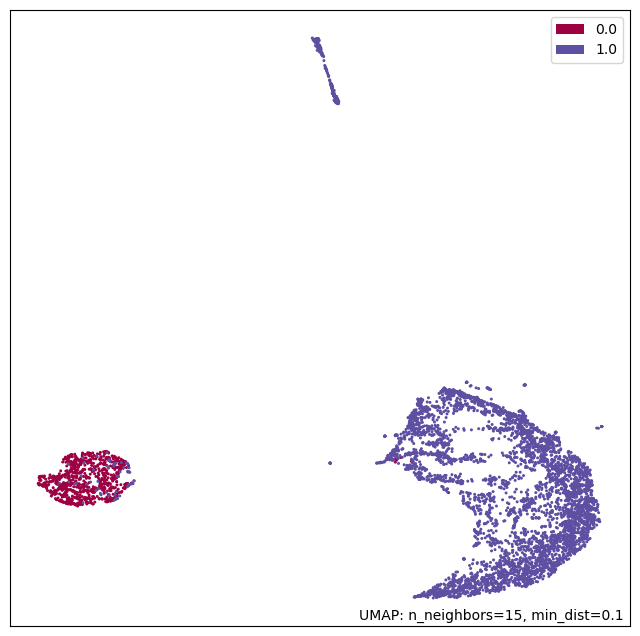

In [83]:
umap.plot.points(mapper, labels=lab)

In [84]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=lab, point_size=5)
umap.plot.show(p)


Loading BokehJS ...